# Face Recognition #3

- We are using: DB1-Youtube (half database from A to I)
- We are performing one different training for each person on the first person video.
- We are then using as testset the other remaining videos.


In [20]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time

print(dlib.DLIB_USE_CUDA)
#dlib.DLIB_USE_CUDA = True

True


The used functions are the same as before.

In [21]:
def createEncodings(dataset_folder, name, detection='cnn'):
    dlib.DLIB_USE_CUDA = True

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    imagePaths = list(paths.list_images(dataset_folder))

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []

    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        name = imagePath.split(os.path.sep)[-2]

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        image = cv2.imread(imagePath)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)

    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings...")
    data = {"encodings": knownEncodings, "names": knownNames}
    name = "./encodings/" + name.split('/')[2] + '.pkl'
    print(name)
    f = open(name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [22]:
def faceRecognition(image, encodings, detection='cnn', show=False):
    start = time.time()
    # the image is already converted in an rgb format
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # format used by openCV
    data = encodings

    # detect the (x, y)-coordinates of the bounding boxes corresponding
    # to each face in the input image, then compute the facial embeddings
    # for each face
    boxes = face_recognition.face_locations(rgb,model=detection)
    encodings = face_recognition.face_encodings(rgb, boxes)

    # initialize the list of names for each face detected
    names = []

    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"],
            encoding)
        name = "unknown"

        # check to see if we have found a match
        if True in matches:
            # find the indexes of all matched faces then initialize a
            # dictionary to count the total number of times each face
            # was matched
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}

            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                name = data["names"][i]
                counts[name] = counts.get(name, 0) + 1

            # determine the recognized face with the largest number of
            # votes (note: in the event of an unlikely tie Python will
            # select first entry in the dictionary)
            name = max(counts, key=counts.get)

        # update the list of names
        try:
            name = name.split('/')[2]
        except:
            name = name
        names.append(name)

    # loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)
    
    
    stop = time.time()
    #print('Time needed:', stop-start, 'sec')
    # show the output image
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        print(names)
        plt.imshow(rgb)
        plt.show()
    return names

def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data
    

In [32]:
def faceRecOnFolder(dataset_folder, encodings, correct_person, detection='cnn', min_threshold = 0.75, show=False):
    imagePaths = list(paths.list_images(dataset_folder))

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    total_frames = len(imagePaths)
    start = time.time()
    
    min_frames = total_frames * 50 / 100
    min_threshold = min_threshold
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    print("[INFO] elements:", total_frames)

    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        image = imageRead(imagePath, show=False)
        person_rec = faceRecognition(image, encodings, detection='cnn', show=True)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            person = person_rec[0]
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
    #for ends
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate
        

To perform this kind of test, we need to select the people in the database that have more than one video associated to them. We are producing a file containing the name of the selected persons use the following code. 

The file 'valid.txt' is already created and stored.

In [33]:
import os

def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            del dirs[:]
            

def produceNamesFile(path):
    count = 0
    files = 0
    folders = 0
    f = open("valid.txt", "w")
    #path = "./DB1-Youtube/frame_images_DB"

    for name, dirnames, filenames in walklevel(path):
        if(name != "./DB1-Youtube/frame_images_DB"):
            nfolders = len(dirnames)
            if( nfolders > 1):
                count +=1
                ## we are just using people that have more than one video!
                f.write(name.split("\\")[1] + "\n")
                print(name, dirnames, nfolders)

    print("Number of people useful for the test:", count)
    print("FINE")
    f.close()
    return

In [25]:
#path = "./DB1-Youtube/frame_images_DB"
#produceNamesFile(path)

Let's start the testing script

In [35]:
test_path = './frame_images_DB/'
file_path = './valid.txt'

def performTest(min_v=0, max_v=100000, threshold=0.75, log=False):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    
    count = 0
    n_test = 0
    n_correct = 0
    filev = open("./valid.txt", "r")
    valid_persons = filev.readlines()
    filev.close()
    
    if( log == True):
        logfile = open("./logs/log" + str(min_v) +"-" + str(max_v) + ".txt", "w")
        
    for person in valid_persons:
        count = count +1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        person = person[0:len(person)-1]
        test_folder = test_path + person
        #test_folder = test_folder.replace("/", "\\")
        print(test_folder)
        # create the enconding related to first folder of the person
        folder_list = os.listdir(test_folder)
        first_n_folder = folder_list[0]
        train_folder = test_folder + "/" + first_n_folder
        res = os.path.exists("./encodings/" + person + ".pkl")
        if(res == False):
            createEncodings(train_folder, person)
        
        # test the encodings of testset
        train_flag = 0
        for n_folder in folder_list:
            if( train_flag == 0):
                train_flag = 1
                continue
            
            n_test += 1
            folder = test_folder + "/" + n_folder
            encoding = encodingsRead("./encodings/" + person + ".pkl")
            v, a, b, c = faceRecOnFolder(folder, encoding, person, min_threshold=threshold, show=True)
            if(log== True):
                line = person + " " + n_folder + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)

            if( v == True):
                n_correct += 1
    
    if(log == True):
        logfile.close()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('Accuracy on videos tested:', n_correct/n_test)
    return


To speed up the test, we are confirming the person appearance in the video using this metric:
- the test is correct if the recognition is over 0.75 after 50% of the images.

Threshold parameter lets us change the value.

In [203]:
performTest(min_v=0, max_v=1, threshold=0.75, log=True)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Aaron_Eckhart
[INFO] Recognizing faces...
[INFO] elements: 49
Aaron_Eckhart Recognized after 25 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 3.7094242572784424
-------------------------
TEST ENDED
-------------------------
Accuracy on videos tested: 1.0


In [177]:
performTest(min_v=0, max_v=20, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Aaron_Eckhart
[INFO] Recognizing faces...
[INFO] elements: 49
Aaron_Eckhart Recognized after 25 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 3.6800577640533447
./frame_images_DB/Aaron_Tippin
[INFO] Recognizing faces...
[INFO] elements: 83
Aaron_Tippin Recognized after 42 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 11.250036478042603
./frame_images_DB/Abba_Eban
[INFO] Recognizing faces...
[INFO] elements: 237
Abba_Eban Recognized after 119 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 17.499829530715942
./frame_images_DB/Abdel_Aziz_Al-Hakim
[INFO] Recognizing faces...
[INFO] elements: 285
Abdel_Aziz_Al-Hakim Recognized after 285 with accuracy: 0.17543859649122806
Not detected: 0.8245614035087719 . Wrong recognition: 0.0
Time: 61.180126667022705
[INFO] Recognizing faces...
[INFO] elements: 93
Abdel_Aziz_Al-Hakim Recognized after 65 with a

In [204]:
performTest(min_v=21, max_v=60, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Alan_Ball
[INFO] Recognizing faces...
[INFO] elements: 719
Alan_Ball Recognized after 360 with accuracy: 0.9972222222222222
Not detected: 0.002777777777777778 . Wrong recognition: 0.0
Time: 78.08727550506592
[INFO] Recognizing faces...
[INFO] elements: 432
Alan_Ball Recognized after 217 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 32.22973966598511
./frame_images_DB/Alan_Dershowitz
[INFO] Recognizing faces...
[INFO] elements: 57
Alan_Dershowitz Recognized after 57 with accuracy: 0.05263157894736842
Not detected: 0.9473684210526315 . Wrong recognition: 0.0
Time: 7.156665802001953
./frame_images_DB/Alastair_Campbell
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Alastair_Campbell.pkl
[INFO] Recognizing faces...
[INFO] elements: 101
Alastair_Campbell Recognized after 51 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 11.04375147819519
[INFO

Alexandre_Despatie Recognized after 63 with accuracy: 0.1111111111111111
Not detected: 0.8888888888888888 . Wrong recognition: 0.0
Time: 10.513628005981445
./frame_images_DB/Alexandre_Herchcovitch
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Alexandre_Herchcovitch.pkl
[INFO] Recognizing faces...
[INFO] elements: 219
Alexandre_Herchcovitch Recognized after 110 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 31.592071056365967
./frame_images_DB/Alexis_Bledel
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Alexis_Bledel.pkl
[INFO] Recognizing faces...
[INFO] elements: 61
Alexis_Bledel Recognized after 61 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.492252349853516
[INFO] Recognizing faces...
[INFO] elements: 55
Alexis_Bledel Recognized after 28 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 4.3108930587768555
./frame_images_DB/Alexis_Dennisoff
[INFO] quantifying faces...
[I

Alma_Powell Recognized after 93 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 21.35979199409485
./frame_images_DB/Alvaro_Silva_Calderon
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Alvaro_Silva_Calderon.pkl
[INFO] Recognizing faces...
[INFO] elements: 185
Alvaro_Silva_Calderon Recognized after 185 with accuracy: 0.2864864864864865
Not detected: 0.7135135135135136 . Wrong recognition: 0.0
Time: 30.035085201263428
[INFO] Recognizing faces...
[INFO] elements: 181
Alvaro_Silva_Calderon Recognized after 165 with accuracy: 0.7515151515151515
Not detected: 0.24848484848484848 . Wrong recognition: 0.0
Time: 49.74994254112244
[INFO] Recognizing faces...
[INFO] elements: 53
Alvaro_Silva_Calderon Recognized after 53 with accuracy: 0.20754716981132076
Not detected: 0.7924528301886793 . Wrong recognition: 0.0
Time: 8.924813747406006
./frame_images_DB/Alvaro_Uribe
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Alvaro_Uribe.pkl

In [16]:
performTest(min_v=61, max_v=100, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Al_Gore
[INFO] Recognizing faces...
[INFO] elements: 48
Al_Gore Recognized after 25 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 2.7222437858581543
[INFO] Recognizing faces...
[INFO] elements: 67
Al_Gore Recognized after 34 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 12.320942878723145
[INFO] Recognizing faces...
[INFO] elements: 56
Al_Gore Recognized after 29 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 4.14927864074707
./frame_images_DB/Al_Leiter
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Al_Leiter.pkl
[INFO] Recognizing faces...
[INFO] elements: 72
Al_Leiter Recognized after 72 with accuracy: 0.3194444444444444
Not detected: 0.6805555555555556 . Wrong recognition: 0.0
Time: 19.270487546920776
./frame_images_DB/Al_Pacino
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Al_Pacino.pkl

[INFO] serializing encodings...
./encodings/Andrew_Wetzler.pkl
[INFO] Recognizing faces...
[INFO] elements: 53
Andrew_Wetzler Recognized after 27 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 4.212400674819946
./frame_images_DB/Andre_Agassi
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Andre_Agassi.pkl
[INFO] Recognizing faces...
[INFO] elements: 57
Andre_Agassi Recognized after 29 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 17.019972324371338
./frame_images_DB/Andy_Dick
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Andy_Dick.pkl
[INFO] Recognizing faces...
[INFO] elements: 57
Andy_Dick Recognized after 29 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 4.5435662269592285
./frame_images_DB/Andy_Lau
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Andy_Lau.pkl
[INFO] Recognizing faces...
[INFO] elements: 49
Andy_Lau Recognized after 25 with accurac

Barbra_Streisand Recognized after 57 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 9.685237646102905
./frame_images_DB/Barry_Alvarez
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Barry_Alvarez.pkl
[INFO] Recognizing faces...
[INFO] elements: 294
Barry_Alvarez Recognized after 148 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 30.85470676422119
[INFO] Recognizing faces...
[INFO] elements: 69
Barry_Alvarez Recognized after 35 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 7.314519643783569
[INFO] Recognizing faces...
[INFO] elements: 57
Barry_Alvarez Recognized after 29 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.373316764831543
./frame_images_DB/Barry_Diller
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Barry_Diller.pkl
[INFO] Recognizing faces...
[INFO] elements: 102
Barry_Diller Recognized after 102 with accuracy: 0.0196078431372549
Not detected

In [17]:
performTest(min_v=101, max_v=150, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Bartosz_Kizierowski
[INFO] Recognizing faces...
[INFO] elements: 60
Bartosz_Kizierowski Recognized after 31 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 8.450657367706299
./frame_images_DB/Bashar_Assad
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Bashar_Assad.pkl
[INFO] Recognizing faces...
[INFO] elements: 129
Bashar_Assad Recognized after 65 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 18.479838371276855
./frame_images_DB/BB_King
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/BB_King.pkl
[INFO] Recognizing faces...
[INFO] elements: 65
BB_King Recognized after 33 with accuracy: 0.8181818181818182
Not detected: 0.18181818181818182 . Wrong recognition: 0.0
Time: 20.52591896057129
./frame_images_DB/Beatriz_Merino
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Beatriz_Merino.pkl
[INFO] 

[INFO] serializing encodings...
./encodings/Biljana_Plavsic.pkl
[INFO] Recognizing faces...
[INFO] elements: 309
Biljana_Plavsic Recognized after 155 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 45.14567995071411
[INFO] Recognizing faces...
[INFO] elements: 121
Biljana_Plavsic Recognized after 61 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 28.08718490600586
./frame_images_DB/Bill_Belichick
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Bill_Belichick.pkl
[INFO] Recognizing faces...
[INFO] elements: 156
Bill_Belichick Recognized after 141 with accuracy: 0.75177304964539
Not detected: 0.24822695035460993 . Wrong recognition: 0.0
Time: 41.679370641708374
./frame_images_DB/Bill_Bradley
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Bill_Bradley.pkl
[INFO] Recognizing faces...
[INFO] elements: 77
Bill_Bradley Recognized after 39 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time:

Carlos_Ghosn Recognized after 32 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 5.436219930648804
./frame_images_DB/Carlos_Iturgaitz
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Carlos_Iturgaitz.pkl
[INFO] Recognizing faces...
[INFO] elements: 214
Carlos_Iturgaitz Recognized after 108 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 14.277935981750488
[INFO] Recognizing faces...
[INFO] elements: 750
Carlos_Iturgaitz Recognized after 376 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 61.8292932510376
[INFO] Recognizing faces...
[INFO] elements: 304
Carlos_Iturgaitz Recognized after 153 with accuracy: 0.9411764705882353
Not detected: 0.058823529411764705 . Wrong recognition: 0.0
Time: 24.291199684143066
./frame_images_DB/Carlos_Menem
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Carlos_Menem.pkl
[INFO] Recognizing faces...
[INFO] elements: 75
Carlos_Menem Recognized after 38 

In [18]:
performTest(min_v=151, max_v=201, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Caroline_Kennedy
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Caroline_Kennedy.pkl
[INFO] Recognizing faces...
[INFO] elements: 219
Caroline_Kennedy Recognized after 110 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 50.772592067718506
./frame_images_DB/Caroline_Link
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Caroline_Link.pkl
[INFO] Recognizing faces...
[INFO] elements: 142
Caroline_Link Recognized after 142 with accuracy: 0.007042253521126761
Not detected: 0.9929577464788732 . Wrong recognition: 0.0
Time: 21.932411193847656
./frame_images_DB/Carrie-Anne_Moss
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Carrie-Anne_Moss.pkl
[INFO] Recognizing faces...
[INFO] elements: 128
Carrie-Anne_Moss Recognized after 65 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 10.388159036636353
[INFO] 

[INFO] serializing encodings...
./encodings/Charles_Ingram.pkl
[INFO] Recognizing faces...
[INFO] elements: 67
Charles_Ingram Recognized after 67 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.979509592056274
./frame_images_DB/Charles_Schumer
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Charles_Schumer.pkl
[INFO] Recognizing faces...
[INFO] elements: 60
Charles_Schumer Recognized after 60 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.081033945083618
[INFO] Recognizing faces...
[INFO] elements: 449
Charles_Schumer Recognized after 449 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 73.56997418403625
./frame_images_DB/Charlie_Coles
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Charlie_Coles.pkl
[INFO] Recognizing faces...
[INFO] elements: 52
Charlie_Coles Recognized after 27 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 3.7166686058044434
[INFO] 

[INFO] serializing encodings...
./encodings/Christine_Arron.pkl
[INFO] Recognizing faces...
[INFO] elements: 55
Christine_Arron Recognized after 28 with accuracy: 0.8928571428571429
Not detected: 0.10714285714285714 . Wrong recognition: 0.0
Time: 12.761344194412231
./frame_images_DB/Christine_Ebersole
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Christine_Ebersole.pkl
[INFO] Recognizing faces...
[INFO] elements: 54
Christine_Ebersole Recognized after 28 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 7.817756175994873
[INFO] Recognizing faces...
[INFO] elements: 114
Christine_Ebersole Recognized after 58 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 9.169103622436523
./frame_images_DB/Christine_Gregoire
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Christine_Gregoire.pkl
[INFO] Recognizing faces...
[INFO] elements: 53
Christine_Gregoire Recognized after 27 with accuracy: 1.0
Not detected: 0.0

In [19]:
performTest(min_v=202, max_v=350, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Chris_Dodd
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Chris_Dodd.pkl
[INFO] Recognizing faces...
[INFO] elements: 247
Chris_Dodd Recognized after 124 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 19.885433197021484
./frame_images_DB/Chris_Matthews
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Chris_Matthews.pkl
[INFO] Recognizing faces...
[INFO] elements: 197
Chris_Matthews Recognized after 99 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 22.682201385498047
[INFO] Recognizing faces...
[INFO] elements: 249
Chris_Matthews Recognized after 125 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 20.026572227478027
[INFO] Recognizing faces...
[INFO] elements: 153
Chris_Matthews Recognized after 77 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 12.278380393981934
./frame_image

Clark_Randt Recognized after 39 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 9.966196298599243
[INFO] Recognizing faces...
[INFO] elements: 145
Clark_Randt Recognized after 73 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 18.730040073394775
[INFO] Recognizing faces...
[INFO] elements: 125
Clark_Randt Recognized after 63 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 16.183677911758423
./frame_images_DB/Claudette_Robinson
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Claudette_Robinson.pkl
[INFO] Recognizing faces...
[INFO] elements: 373
Claudette_Robinson Recognized after 187 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 52.59708547592163
./frame_images_DB/Claudio_Abbado
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Claudio_Abbado.pkl
[INFO] Recognizing faces...
[INFO] elements: 97
Claudio_Abbado Recognized after 49 with accuracy: 1.0
Not detected:

Courtney_Cox Recognized after 31 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 8.631920337677002
[INFO] Recognizing faces...
[INFO] elements: 59
Courtney_Cox Recognized after 30 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 5.211372137069702
./frame_images_DB/Courtney_Love
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Courtney_Love.pkl
[INFO] Recognizing faces...
[INFO] elements: 57
Courtney_Love Recognized after 57 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.746122121810913
./frame_images_DB/Craig_David
[INFO] quantifying faces...
[INFO] serializing encodings...
./encodings/Craig_David.pkl
[INFO] Recognizing faces...
[INFO] elements: 89
Craig_David Recognized after 45 with accuracy: 0.7777777777777778
Not detected: 0.2222222222222222 . Wrong recognition: 0.0
Time: 17.183923959732056
[INFO] Recognizing faces...
[INFO] elements: 185
Craig_David Recognized after 185 with accuracy: 0.5891891891

In [9]:
performTest(min_v=351, max_v=500, threshold=0.75, log=False)

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/Felipe_De_Borbon
[INFO] Recognizing faces...
[INFO] elements: 813
Felipe_De_Borbon Recognized after 407 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 94.61837577819824
./frame_images_DB/Felix_Sanchez
[INFO] Recognizing faces...
[INFO] elements: 53
Felix_Sanchez Recognized after 27 with accuracy: 0.9629629629629629
Not detected: 0.037037037037037035 . Wrong recognition: 0.0
Time: 5.8736183643341064
./frame_images_DB/Ferenc_Madl
[INFO] Recognizing faces...
[INFO] elements: 69
Ferenc_Madl Recognized after 35 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 8.669835567474365
./frame_images_DB/Fernando_Henrique_Cardoso
[INFO] Recognizing faces...
[INFO] elements: 445
Fernando_Henrique_Cardoso Recognized after 223 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 59.54853177070618
[INFO] Recognizing faces...
[INFO] elements: 545
Fernando_Henrique_Cardo

Frank_Keating Recognized after 34 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 5.0613062381744385
[INFO] Recognizing faces...
[INFO] elements: 85
Frank_Keating Recognized after 43 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.404782772064209
./frame_images_DB/Frank_Solich
[INFO] Recognizing faces...
[INFO] elements: 95
Frank_Solich Recognized after 48 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 7.123299598693848
[INFO] Recognizing faces...
[INFO] elements: 69
Frank_Solich Recognized after 35 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 5.280007362365723
./frame_images_DB/Frank_Stallone
[INFO] Recognizing faces...
[INFO] elements: 53
Frank_Stallone Recognized after 27 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.841557741165161
./frame_images_DB/Franz_Fischler
[INFO] Recognizing faces...
[INFO] elements: 53
Franz_Fischler Recognized after 27 with accuracy: 1.0
Not detec

Gene_Hackman Recognized after 91 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 18.12077569961548
./frame_images_DB/Gene_Robinson
[INFO] Recognizing faces...
[INFO] elements: 205
Gene_Robinson Recognized after 103 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 16.105613231658936
[INFO] Recognizing faces...
[INFO] elements: 103
Gene_Robinson Recognized after 52 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 15.230799913406372
./frame_images_DB/Gennifer_Flowers
[INFO] Recognizing faces...
[INFO] elements: 86
Gennifer_Flowers Recognized after 44 with accuracy: 0.9318181818181818
Not detected: 0.06818181818181818 . Wrong recognition: 0.0
Time: 20.432669401168823
./frame_images_DB/Geno_Auriemma
[INFO] Recognizing faces...
[INFO] elements: 57
Geno_Auriemma Recognized after 29 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.5920000076293945
./frame_images_DB/Geoffrey_Rush
[INFO] Recognizing faces...
[INFO] el

Hank_McKinnell Recognized after 152 with accuracy: 0.618421052631579
Not detected: 0.3815789473684211 . Wrong recognition: 0.0
Time: 23.91460943222046
[INFO] Recognizing faces...
[INFO] elements: 54
Hank_McKinnell Recognized after 54 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.453423500061035
./frame_images_DB/Hank_Stram
[INFO] Recognizing faces...
[INFO] elements: 84
Hank_Stram Recognized after 43 with accuracy: 0.8604651162790697
Not detected: 0.13953488372093023 . Wrong recognition: 0.0
Time: 14.322739124298096
./frame_images_DB/Harald_Ringstorff
[INFO] Recognizing faces...
[INFO] elements: 48
Harald_Ringstorff Recognized after 25 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.940884590148926
./frame_images_DB/Harrison_Ford
[INFO] Recognizing faces...
[INFO] elements: 96
Harrison_Ford Recognized after 57 with accuracy: 0.7543859649122807
Not detected: 0.24561403508771928 . Wrong recognition: 0.0
Time: 8.959415197372437
[INFO] Recogniz

Ivan_Helguera Recognized after 119 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 13.839812755584717
-------------------------
TEST ENDED
-------------------------
Accuracy on videos tested: 0.8771929824561403


Now, let's build common statistics for all the training files.

In [27]:
import os
files = os.listdir("./logs")

total_files = 0
recognized = 0
notdetected = 0
wrong = 0
confirmed = 0

for f in files:
    if( f.startswith('log') == True):
        filev = open(f, "r")
        lines = filev.readlines()
        for line in lines:
            total_files += 1
            
            rec_flag = line.split(' ')[2]
            rec_percentage = float(line.split(' ')[3])
            notdec_percentage = float(line.split(' ')[4])
            notrec_percentage = float(line.split(' ')[5])
            
            recognized = recognized + rec_percentage
            notdetected = notdetected + notdec_percentage
            wrong = wrong + notrec_percentage
            if(rec_flag == 'True'):
                confirmed = confirmed + 1
                
confirmed_rate = confirmed / total_files

positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files


Percentage of images correctly recognized: 0.8617362976117258


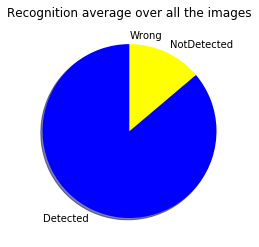

In [28]:
labels = ['Detected', 'NotDetected', 'Wrong']
colors = ['Blue', 'Yellow', 'Orange']
sizes1 = [positive, undetected, negative]
print('Percentage of images correctly recognized:', positive)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.show()

Percentage of people confirmed using our metric: 0.853416149068323


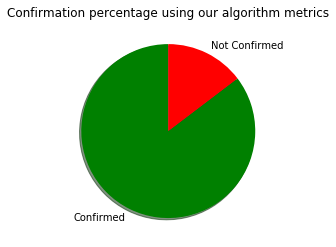

In [29]:
labels = ['Confirmed', 'Not Confirmed']
colors = ['Green', 'Red']
sizes1 = [confirmed_rate, (1 - confirmed_rate)]
print('Percentage of people confirmed using our metric:', confirmed_rate)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Confirmation percentage using our algorithm metrics')
plt.show()

We are now trying with our custom dataset. 

We took some guys' pictures (respecting GDPR, of course) and we are testing our algorithm on it.

-------------------------
TEST STARTED
-------------------------
./frame_images_DB/z_William
[INFO] Recognizing faces...
[INFO] elements: 5
['z_William']


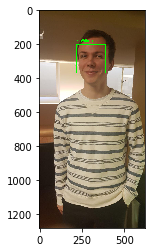

['z_William']


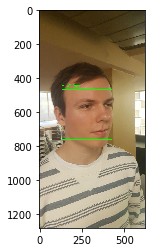

['z_William']


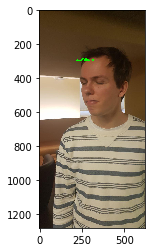

['z_William']


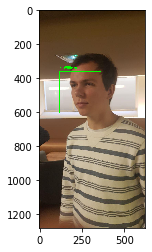

['z_William']


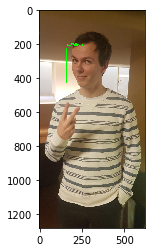

z_William Recognized after 5 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 7.802924394607544
./frame_images_DB/z_Rutger
[INFO] Recognizing faces...
[INFO] elements: 3
['z_Rutger']


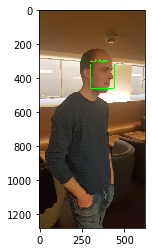

['z_Rutger']


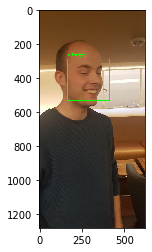

['z_Rutger']


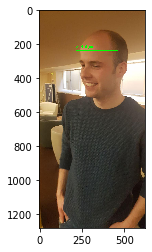

z_Rutger Recognized after 3 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 6.231365919113159
./frame_images_DB/z_Reinhilde
[INFO] Recognizing faces...
[INFO] elements: 3
['z_Reinhilde']


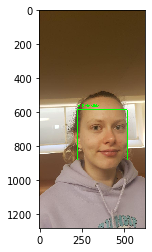

['z_Reinhilde']


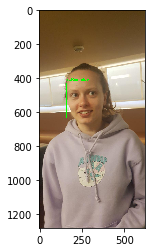

['z_Reinhilde']


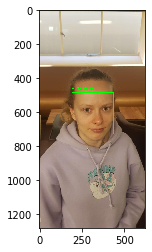

z_Reinhilde Recognized after 3 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 8.692739486694336
./frame_images_DB/z_Lotte
[INFO] Recognizing faces...
[INFO] elements: 4
['z_Lotte']


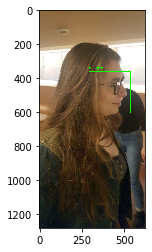

['z_Lotte']


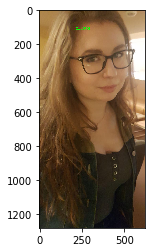

['z_Lotte']


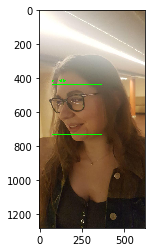

['z_Lotte', 'z_Lotte']


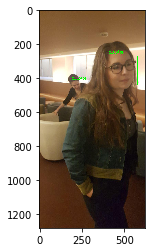

z_Lotte Recognized after 4 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 10.39919400215149
./frame_images_DB/z_Dounia
[INFO] Recognizing faces...
[INFO] elements: 2
['z_Dounia']


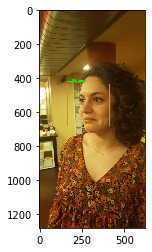

['z_Dounia']


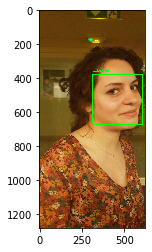

z_Dounia Recognized after 2 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 3.63236665725708
./frame_images_DB/z_Aram
[INFO] Recognizing faces...
[INFO] elements: 2
['z_Aram']


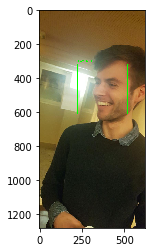

['z_Aram']


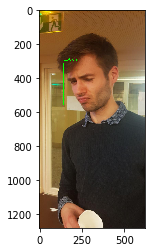

z_Aram Recognized after 2 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 2.727705717086792
-------------------------
TEST ENDED
-------------------------
Accuracy on videos tested: 1.0


In [36]:
performTest(min_v=456, max_v=500, threshold=1.01, log=False)